In [1]:
!pip install wandb -q

In [2]:
!wandb login 03697d38e9eca7bd6d9b6de1fc24cb8cd504fd51

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!cp /kaggle/input/task-2/logs.json /kaggle/working/

In [ ]:
!mkdir /kaggle/working/weights

In [ ]:
!cp /kaggle/input/task-2/weights_epoch_02.h5 /kaggle/working/weights/

In [4]:
!nvidia-smi

Wed Jan 31 04:57:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
!pip install scikit-image albumentations -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from skimage.metrics import structural_similarity as ssim
import albumentations as A

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
class DataSequence(Sequence):
    def __init__(self, directory, batch_size, image_size):
        self.directory = directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_files = os.listdir(directory)
        self.augmentation_transform = A.Compose([
            A.Rotate(limit=20, p=1.0),
            A.HorizontalFlip(p=0.5)
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for file in batch_files:
            image_path = os.path.join(self.directory, file)
            image = tf.keras.utils.load_img(image_path, target_size=(self.image_size))

            # Применяем обработку
            processed_image = self.processing(image)
            augmented_image = self.augmentation(processed_image)

            batch_images.append(augmented_image)

        return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_images)  # Returning input and target as same for autoencoder

    def processing(self, image):
        # Normalize pixels
        normalized_image = np.array(image) / 255.0
        return normalized_image

    def augmentation(self, image):
        augmented = self.augmentation_transform(image=image)
        return augmented['image']

In [8]:
# Параметры загрузчика данных
data_directory = "/kaggle/input/animefacedataset/images"
batch_size = 32
image_size = (64, 64, 3)  # Размер изображений

# Получаем список файлов изображений
image_files = os.listdir(data_directory)
num_images = len(image_files)

input_images = DataSequence(data_directory, batch_size, image_size)

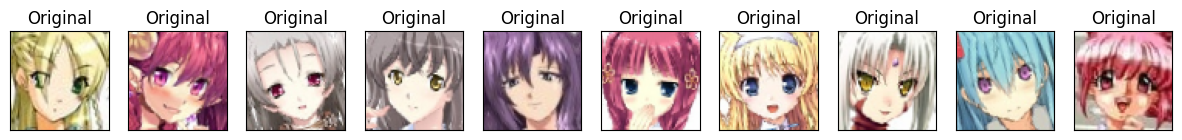

In [9]:
# Отображение сетки выборочных изображений
n = 10  # Количество изображений для отображения (выберите по желанию)

# Отображение оригинальных и реконструированных изображений
plt.figure(figsize=(15, 6))
for i in range(n):
    # Оригинальные изображения
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_images[0][0][i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, input_size=(128, 128, 3), latent_dim=128, batch_size=32):
        super().__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_encoder(self):
        inputs = Input(shape=self.input_size, name='encoder_input')
        x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, 3, activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Flatten()(x)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        z = Sampling()((z_mean, z_log_var))
        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(8 * 8 * 128, activation='relu')(latent_inputs)
        x = Reshape((8, 8, 128))(x)
        x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
        x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
        x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
        decoder = Model(latent_inputs, outputs, name='decoder')
        return decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(data)
        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

#         return {
#             "total_loss": total_loss,
#             "reconstruction_loss": reconstruction_loss,
#             "kl_loss": kl_loss
#         }
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def compute_loss(self, x):
        z_mean, z_log_var, z = self.encoder(x[0])
        reconstructed = self.decoder(z)

        # Compute reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.mean_squared_error(x, reconstructed)
        )
        reconstruction_loss *= self.input_size[0] * self.input_size[1]

        # Compute KL divergence regularization loss
#         kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.math.exp(z_log_var))
        
        # from docs
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        return total_loss, reconstruction_loss, kl_loss


    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

In [23]:
from keras.callbacks import LambdaCallback, Callback, ModelCheckpoint

In [24]:
class SSIMCallback(tf.keras.callbacks.Callback):
    def __init__(self, input_images):
        super(SSIMCallback, self).__init__()
        self.input_images = input_images
        self.ssim_scores = []

    def on_epoch_end(self, epoch, logs=None):
        ssim_score = 0
        reconstructed_images = self.model.predict(self.input_images[0][0])
        
        for i in range(len(reconstructed_images)):
            original_image = self.input_images[0][0][i].numpy().astype(np.float32)
            reconstructed_image = reconstructed_images[i].astype(np.float32)
            
            data_range = original_image.max() - original_image.min()
            ssim_score = ssim(original_image, reconstructed_image, channel_axis=2, data_range=data_range)
        ssim_score /= len(reconstructed_images)
        self.ssim_scores.append(ssim)
        print(f'SSIM after epoch {epoch}: {ssim_score}')

In [25]:
class VisualizeCallback(tf.keras.callbacks.Callback):
    def __init__(self, input_images):
        self.input_images = input_images

    def on_epoch_end(self, epoch, logs=None):
        plot_images()

In [26]:
def plot_images(n_images: int = 10):
    # Предсказание реконструированных изображений
    reconstructed_images = vae.predict(input_images[0][0])

    # Отображение оригинальных и реконструированных изображений
    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Оригинальные изображения
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(input_images[0][0][i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Реконструированные изображения
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [27]:
class LogToJsonCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename='logs.json'):
        super(LogToJsonCallback, self).__init__()
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        with open(self.filename, 'a') as f:
            log_entry = {
                'epoch': epoch + 1,
                'loss': float(logs.get('loss')),
                'reconstruction_loss': float(logs.get('reconstruction_loss')),
                'kl_loss': float(logs.get('kl_loss'))
            }
            json.dump(log_entry, f)
            f.write('\n')

In [28]:
# Определите путь к файлу, в который будут сохраняться веса модели
checkpoint_path = "/kaggle/working/weights_epoch_{epoch:02d}.weights.h5"

# Создайте коллбэк ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Сохраняем только веса, а не всю модель
    save_freq='epoch',       # Сохраняем после каждой эпохи
    save_best_only=False,
    verbose=1
)

In [30]:
log_dir = f"/kaggle/working/"
latent_dim = 64

In [20]:
wandb.init(project='VAE')

wandb: Currently logged in as: pan_ae (pnntly). Use `wandb login --relogin` to force relogin


In [31]:
vae = VAE(input_size=image_size, latent_dim=latent_dim, batch_size=batch_size)

# Если что-то пойдет не так (не дай бог!)
# _ = vae(tf.zeros((1, *image_size)))  
# vae.load_weights("/kaggle/working/weights_epoch_02.h5")

vae.compile(optimizer="adam", loss='binary_crossentropy')



In [ ]:
# log_freq=1

In [ ]:
history = vae.fit(input_images,
                  epochs=20,
                 callbacks=[WandbMetricsLogger(),
                            VisualizeCallback(input_images),
                           SSIMCallback(input_images),
                           LogToJsonCallback(filename="/kaggle/working/logs.json"),
                           checkpoint_callback])

Epoch 1/20
1104/1987 [===============>..............] - ETA: 10:54 - loss: 214.8922 - reconstruction_loss: 155.5561 - kl_loss: 26.8838

In [ ]:
latent_dim = 64
n = 10

In [ ]:
# Генерация изображений из скрытого пространства
# Генерация случайных точек в скрытом пространстве
latent_points = np.random.normal(size=(n, latent_dim))

# Предсказание изображений из скрытого пространства
generated_images = vae.decoder.predict(latent_points)

# Отображение сгенерированных изображений
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i])
    plt.title("Generated")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()